# Comparative Analysis of SIFT/BoW, **CNNs**, and SSL Techniques for Image Classification
_Alessio De Luca_ |
_Simone Vaccari_ |
_Davide Vettore_

## Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install torchsummary
    from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR, ReduceLROnPlateau

from sklearn.metrics import precision_recall_fscore_support

## Load the Data
> The scripts have been run on the Kaggle framework, the preprocessed data is stored [here](https://www.kaggle.com/datasets/momiqb/ifoodbalanced).

In [ ]:
# Root path
path = '/kaggle/input/ifoodbalanced/'

# Read the training, validation, and test dataframes
train_df = pd.read_csv(path + 'balanced_trainset.csv')
valid_df = pd.read_csv(path + 'valset.csv')
test_df = pd.read_csv(path + 'val_labels.csv')

# Define paths for training/validation and test images
train_val_img_dir = path + 'train_set/train_set/'
test_img_dir = path + 'val_set/val_set/'

## Dataset and Dataloaders

In [ ]:
# Train on GPU if available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Set device
device = torch.device("cuda:0" if train_on_gpu else "cpu")

print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [ ]:
# Dataset class to properly load images
class FoodDataset(Dataset):

    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name, label = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.img_dir, img_name)))

        if self.transform:
            img = self.transform(image=img)['image']

        return img, label

In [ ]:
# Define augmentations for training images
transform_train = A.Compose([
    A.Resize(width=256, height=256),      # resizing (256x256)
    A.Rotate(limit=30, p=0.5),            # random rotation in range [-30°,30°]
    A.HorizontalFlip(p=0.5),              # random horizontal flip
    A.ColorJitter (brightness=(0.8, 1), contrast=(0.8, 1), saturation=(0.8, 1), hue=0, p=0.5),    # random color jitter
    A.VerticalFlip(p=0.5),                                                                        # random vertical flip
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),                           # normalize
    ToTensorV2(),                           # convert to tensor
])

# Define validation/testing transformations
transform_valid = A.Compose([
    A.Resize(width=256, height=256),          # resize (256x256)
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),   # normalize
    ToTensorV2(),                             # convert to tensor
])

# Set batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = 4

# Initialize dataset and dataloaders
train_dataset = FoodDataset(train_df, train_val_img_dir, transform=transform_train)
valid_dataset = FoodDataset(valid_df, train_val_img_dir, transform=transform_valid)
test_dataset = FoodDataset(test_df, test_img_dir, transform=transform_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
# Plot a batch of images with the corresponding label
def visualize_batch(loader):
    # Get batch
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(len(images), 1, figsize=(10, len(images)*2))

    for i in range(len(images)):
        img = images[i].permute(1, 2, 0).numpy()

        # Display image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Class: {labels[i].item()}")

    plt.tight_layout()
    plt.show()

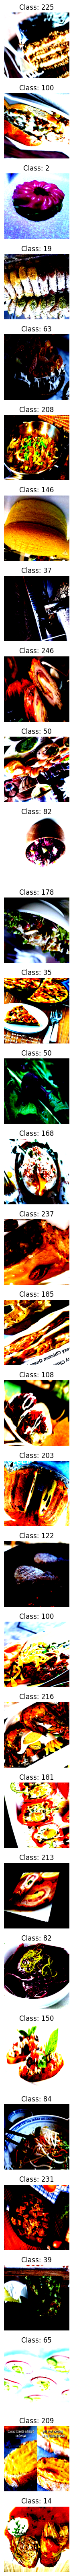

In [ ]:
visualize_batch(train_loader)

## Models Definition

### CNN with standard convolutions and Max Pooling

We start with a few bigger kernels, and as we go deeper we decrease the kernel size and increase the number of filters used. \
The spatial dimension is halved after every convolutional layer thanks to a 2x2 Max Pooling layer. \
After the convolutional layers, the output, with size 32x8x8 (8x8 spatial size, 32 depth dimension), is flattened and passed through 3 fully-connected layers.

In [ ]:
# First CNN model
class SmallCNN1(nn.Module):
    def __init__(self, num_classes=251):
        super(SmallCNN1, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, padding=2)  # Output: 8x256x256
        self.conv2 = nn.Conv2d(8, 8, kernel_size=5, padding=2)  # Output: 8x128x128 (spatial dim is reduced after MaxPool)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # Output: 16x64x64 (after MaxPool)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1)  # Output: 16x32x32 (after MaxPool)
        self.conv5 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Output: 32x16x16 (after MaxPool)

        # Max Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layers
        self.fc1 = nn.Linear(32 * 8 * 8, 400)  # Output: 400
        self.fc2 = nn.Linear(400, 256)  # Output: 256
        self.fc3 = nn.Linear(256, num_classes)  # Output: num_classes

        # Dropout Layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 8x256x256 -> 8x128x128
        x = self.pool(F.relu(self.conv2(x)))  # 8x128x128 -> 8x64x64
        x = self.pool(F.relu(self.conv3(x)))  # 8x64x64 -> 16x32x32
        x = self.pool(F.relu(self.conv4(x)))  # 16x32x32 -> 16x16x16
        x = self.pool(F.relu(self.conv5(x)))  # 16x16x16 -> 32x8x8

        x = x.view(-1, 32 * 8 * 8)  # Flatten: 32*8*8

        x = F.relu(self.fc1(x))   # 400
        x = self.dropout(x)
        x = F.relu(self.fc2(x))   # 256
        x = self.dropout(x)
        x = self.fc3(x)           # num_classes

        return x

In [ ]:
# Summary of the model
model = SmallCNN1()
model.to(device)
summary(model, input_size=(3, 256, 256))

# 997,107 total params

### CNN with Depthwise Separable Convolutions and Global Average Pooling

**Depthwise separable convolutions** are a type of convolutional operation designed to reduce the computational cost and the number of parameters in a CNN by breaking down the standard convolution operation into two simpler and more efficient operations: **depthwise convolution** and **pointwise convolution**.
A depthwise convolution applies one K×K filter per input channel. A pointwise convolution, applied to the output of the depthwise convolution, combines the information across all channels by applying a 1×1 filter.


**Global Average Pooling** is a pooling operation that reduces the spatial dimensions of a feature map by computing the average of all values in the feature map. By doing this for every feature maps, it effectively "flattens" a feature volume. This allows for a significant parameter reduction, because we no longer need large fully-connected layers.


In [ ]:
# Second CNN Model
class SmallCNN2(nn.Module):
    def __init__(self, num_classes=251):
        super(SmallCNN2, self).__init__()

        # Initial Conv Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)       # Output: 32x256x256
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)      # Output: 32x128x128 (after max pooling)
        self.bn2 = nn.BatchNorm2d(32)

        # Depthwise Separable Convolution Block 1
        self.depthwise1 = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)   # Output: 32x128x128
        self.pointwise1 = nn.Conv2d(32, 64, kernel_size=1)                         # Output: 64x128x128
        self.bn3 = nn.BatchNorm2d(64)

        self.depthwise2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64)   # Output: 64x128x128
        self.pointwise2 = nn.Conv2d(64, 128, kernel_size=1)                        # Output: 128x64x64   (after max pooling)
        self.bn4 = nn.BatchNorm2d(128)

        # Depthwise Separable Convolution Block 2
        self.depthwise3 = nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128)   # Output: 128x64x64
        self.pointwise3 = nn.Conv2d(128, 256, kernel_size=1)                          # Output: 256x64x64
        self.bn5 = nn.BatchNorm2d(256)

        self.depthwise4 = nn.Conv2d(256, 256, kernel_size=3, padding=1, groups=256)   # Output: 256x64x64
        self.pointwise4 = nn.Conv2d(256, 512, kernel_size=1)                          # Output: 512x32x32  (after max pooling)
        self.bn6 = nn.BatchNorm2d(512)

        self.depthwise5 = nn.Conv2d(512, 512, kernel_size=3, padding=1, groups=512)   # Output: 512x32x32
        self.pointwise5 = nn.Conv2d(512, 1024, kernel_size=1)                         # Output: 1024x16x16  (after max pooling)
        self.bn7 = nn.BatchNorm2d(1024)

        # Max Pooling Layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Global Average Pooling and Fully Connected Layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Initial Conv Block
        x = F.relu(self.bn1(self.conv1(x)))   # 3x256x256 -> 32x256x256
        x = F.relu(self.bn2(self.conv2(x)))   # 32x256x256 -> 32x256x256
        x = self.maxpool(x)                   # 32x256x256 -> 32x128x128

        # Depthwise Separable Convolution Block 1
        x = F.relu(self.bn3(self.pointwise1(self.depthwise1(x))))   # 32x128x128 -> 64x128x128
        x = F.relu(self.bn4(self.pointwise2(self.depthwise2(x))))   # 64x128x128 -> 128x128x128
        x = self.maxpool(x)                                         # 128x128x128 -> 128x64x64

        # Depthwise Separable Convolution Block 2
        x = F.relu(self.bn5(self.pointwise3(self.depthwise3(x))))   # 128x64x64 -> 256x64x64
        x = F.relu(self.bn6(self.pointwise4(self.depthwise4(x))))   # 256x64x64 -> 512x64x64
        x = self.maxpool(x)                                         # 512x64x64 -> 512x32x32

        # Depthwise Separable Convolution Block 3
        x = F.relu(self.bn7(self.pointwise5(self.depthwise5(x))))   # 512x32x32 -> 1024x32x32
        x = self.maxpool(x)                                         # 1024x32x32 -> 1024x16x16

        # Global Average Pooling and Fully Connected Layer
        x = self.global_avg_pool(x)         # 1024 x 1 x 1
        x = torch.flatten(x, 1)             # 1024
        x = self.dropout(x)
        x = self.fc(x)                      # 1024 -> num_classes

        return x


In [ ]:
model = SmallCNN2(num_classes=251)
model.to(device)

summary(model, input_size=(3, 256, 256))

# 983,323 total params


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           2,432
       BatchNorm2d-2         [-1, 32, 256, 256]              64
            Conv2d-3         [-1, 32, 256, 256]           9,248
       BatchNorm2d-4         [-1, 32, 256, 256]              64
         MaxPool2d-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 32, 128, 128]             320
            Conv2d-7         [-1, 64, 128, 128]           2,112
       BatchNorm2d-8         [-1, 64, 128, 128]             128
            Conv2d-9         [-1, 64, 128, 128]             640
           Conv2d-10        [-1, 128, 128, 128]           8,320
      BatchNorm2d-11        [-1, 128, 128, 128]             256
        MaxPool2d-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]           1,280
           Conv2d-14          [-1, 256,

## Training

In [ ]:
# Define number of training epochs
EPOCHS = 50

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)


In [ ]:
# Training and validation routine

def train_validate(model, device, train_loader, valid_loader, loss_fn, optimizer, scheduler=None, epochs=EPOCHS, patience=5):
    # Initialize variables for early stopping
    best_model = None
    best_loss = np.inf    # + inf
    curr_patience = patience

    # Initialize variables to save losses and accuracies
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []

    actual_epochs = 0
    start = time.time()

    # Training loop
    for epoch in tqdm(range(epochs)):
        actual_epochs += 1
        # Set model in training mode
        model.train()

        # Initialize epoch variables to compute loss and accuracy
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in tqdm(train_loader):
            # Get images and labels from the data loader
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            # scheduler.step()  # UNCOMMENT IF USING StepLR or CosineAnnealingLR

            train_loss += loss.item() # * images.size(0)

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)    # obtain the prediction by taking the max logit across the columns (1)
            train_total += labels.size(0)
            train_correct += (preds == labels).sum().item()


        # Compute average training loss and accuracy
        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_total
        epoch_train_loss.append(train_loss)
        epoch_train_accuracies.append(train_accuracy*100)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.to(device), labels.to(device)
                # Forward pass
                outputs = model(images)
                val_loss += loss_fn(outputs, labels).item() # * images.size(0)

                # Calculate accuracy
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        # Compute average validation loss and accuracy
        val_loss /= len(valid_loader)
        val_accuracy = val_correct / val_total
        epoch_val_loss.append(val_loss)
        epoch_val_accuracies.append(val_accuracy*100)

        if scheduler:
            scheduler.step(val_loss)    # COMMENT IF USING StepLR or CosineAnnealingLR


        # Track best model and save weights if validation loss improves
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            torch.save(best_model, "/kaggle/working/best-cnn.pth")
            curr_patience = 5
            print("**BEST**", end="")
        else:
            curr_patience -= 1

        # Print training/validation statistics
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {val_loss:.4f}, Valid Accuracy: {val_accuracy:.4f}")

        # Implement early stopping
        if curr_patience <= 0:
            print("Stop training!")
            break

    end = time.time()
    print(f"Total training time: {round(end-start,2)} seconds")

    return epoch_train_loss, epoch_val_loss, epoch_train_accuracies, epoch_val_accuracies, actual_epochs


In [ ]:
epoch_train_loss, epoch_val_loss, epoch_train_accuracies, epoch_val_accuracies, actual_epochs = train_validate(model, device, train_loader,
                                                                                                               valid_loader, criterion, optimizer,
                                                                                                               scheduler=scheduler, epochs=EPOCHS,
                                                                                                               patience=6)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 1/50: Train Loss: 5.1687, Train Accuracy: 0.0285, Valid Loss: 4.7901, Valid Accuracy: 0.0604


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 2/50: Train Loss: 4.8175, Train Accuracy: 0.0561, Valid Loss: 4.6227, Valid Accuracy: 0.0757


  0%|          | 0/2597 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>

  File "/opt/conda/lib/python3.10/site-packages/torch/u

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
Exception ignored in:   File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
        self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

self._shutdown_workers()Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
if w.is_alive():

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
      File 

**BEST**Epoch 3/50: Train Loss: 4.6595, Train Accuracy: 0.0709, Valid Loss: 4.4677, Valid Accuracy: 0.0977


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 4/50: Train Loss: 4.5431, Train Accuracy: 0.0867, Valid Loss: 4.4308, Valid Accuracy: 0.1048


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 5/50: Train Loss: 4.4549, Train Accuracy: 0.0974, Valid Loss: 4.3159, Valid Accuracy: 0.1158


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 6/50: Train Loss: 4.3788, Train Accuracy: 0.1070, Valid Loss: 4.2389, Valid Accuracy: 0.1278


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/op

**BEST**Epoch 7/50: Train Loss: 4.3164, Train Accuracy: 0.1159, Valid Loss: 4.2046, Valid Accuracy: 0.1379


  0%|          | 0/2597 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Traceback (most recent call last):

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__

    Exception ignored in:     Traceback (most recent call last):
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    self._shutdown_workers()


  File "/opt/conda/lib/pyt

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 8/50: Train Loss: 4.2583, Train Accuracy: 0.1238, Valid Loss: 4.1169, Valid Accuracy: 0.1462


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Epoch 9/50: Train Loss: 4.2060, Train Accuracy: 0.1341, Valid Loss: 4.1172, Valid Accuracy: 0.1497


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 10/50: Train Loss: 4.1531, Train Accuracy: 0.1403, Valid Loss: 4.0339, Valid Accuracy: 0.1602


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 11/50: Train Loss: 4.1139, Train Accuracy: 0.1450, Valid Loss: 3.9936, Valid Accuracy: 0.1677


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80><function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    Traceback (most recent call last):
self._shutdown_workers()Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    
    self._shutdown_workers()self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    

if w.is_alive():  File

**BEST**Epoch 12/50: Train Loss: 4.0668, Train Accuracy: 0.1537, Valid Loss: 3.9603, Valid Accuracy: 0.1703


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Exception ignored in: self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>

Traceback (most recent call last):
    Traceback (most recent call last):
self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>    
    
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers


  0%|          | 0/2597 [00:00<?, ?it/s]

self._shutdown_workers()self._shutdown_workers()    
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    if w.is_alive():  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

      File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():        if w.is_alive():if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid =

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 13/50: Train Loss: 4.0321, Train Accuracy: 0.1592, Valid Loss: 3.9053, Valid Accuracy: 0.1831


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 14/50: Train Loss: 3.9969, Train Accuracy: 0.1648, Valid Loss: 3.8839, Valid Accuracy: 0.1836


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 15/50: Train Loss: 3.9608, Train Accuracy: 0.1697, Valid Loss: 3.8369, Valid Accuracy: 0.1937


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 16/50: Train Loss: 3.9282, Train Accuracy: 0.1749, Valid Loss: 3.8028, Valid Accuracy: 0.2021


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80><function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Exception ignored in: 
Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>    <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>    
self._shutdown_workers()self._shutdown_workers()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    

    self._shutdown_workers

**BEST**Epoch 17/50: Train Loss: 3.8960, Train Accuracy: 0.1814, Valid Loss: 3.7954, Valid Accuracy: 0.2012


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>

  0%|          | 0/2597 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80><function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):

Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
self._shutdown_workers()
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
self._shutdown_workers()
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_wor

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 18/50: Train Loss: 3.8655, Train Accuracy: 0.1848, Valid Loss: 3.7625, Valid Accuracy: 0.2076


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 19/50: Train Loss: 3.8305, Train Accuracy: 0.1911, Valid Loss: 3.7616, Valid Accuracy: 0.2070


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 20/50: Train Loss: 3.8103, Train Accuracy: 0.1957, Valid Loss: 3.6761, Valid Accuracy: 0.2169


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Epoch 21/50: Train Loss: 3.7787, Train Accuracy: 0.2020, Valid Loss: 3.7045, Valid Accuracy: 0.2200


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 22/50: Train Loss: 3.7575, Train Accuracy: 0.2044, Valid Loss: 3.6726, Valid Accuracy: 0.2204


  0%|          | 0/2597 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/op

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    Traceback (most recent call last):
self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
Exception ignored in: 
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
if w.is_alive():assert self._parent_pid == os.getpid(), 

**BEST**Epoch 23/50: Train Loss: 3.7328, Train Accuracy: 0.2074, Valid Loss: 3.6719, Valid Accuracy: 0.2261


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 24/50: Train Loss: 3.7074, Train Accuracy: 0.2107, Valid Loss: 3.6563, Valid Accuracy: 0.2286


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 25/50: Train Loss: 3.6829, Train Accuracy: 0.2147, Valid Loss: 3.6181, Valid Accuracy: 0.2263


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 26/50: Train Loss: 3.6619, Train Accuracy: 0.2203, Valid Loss: 3.5609, Valid Accuracy: 0.2435


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Epoch 27/50: Train Loss: 3.6356, Train Accuracy: 0.2243, Valid Loss: 3.5830, Valid Accuracy: 0.2358


  0%|          | 0/2597 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
self._shutdown_workers()Traceback (most recent call last):
  File "/opt/conda/li

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Exception ignored in:     Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__

    Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__

      File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/opt/conda/lib/python3.10/s

**BEST**Epoch 28/50: Train Loss: 3.6191, Train Accuracy: 0.2261, Valid Loss: 3.5132, Valid Accuracy: 0.2484


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Epoch 29/50: Train Loss: 3.5950, Train Accuracy: 0.2313, Valid Loss: 3.5563, Valid Accuracy: 0.2422


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Epoch 30/50: Train Loss: 3.5719, Train Accuracy: 0.2331, Valid Loss: 3.5527, Valid Accuracy: 0.2380


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 31/50: Train Loss: 3.5497, Train Accuracy: 0.2380, Valid Loss: 3.5062, Valid Accuracy: 0.2518


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 32/50: Train Loss: 3.5260, Train Accuracy: 0.2418, Valid Loss: 3.4424, Valid Accuracy: 0.2632


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
self._shutdown_workers()
    self._shutdown_workers()
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
self._s

Epoch 33/50: Train Loss: 3.5098, Train Accuracy: 0.2449, Valid Loss: 3.4665, Valid Accuracy: 0.2586


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Epoch 34/50: Train Loss: 3.4924, Train Accuracy: 0.2479, Valid Loss: 3.4607, Valid Accuracy: 0.2642


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 35/50: Train Loss: 3.4722, Train Accuracy: 0.2510, Valid Loss: 3.4384, Valid Accuracy: 0.2691


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 36/50: Train Loss: 3.4560, Train Accuracy: 0.2575, Valid Loss: 3.3884, Valid Accuracy: 0.2804


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Epoch 37/50: Train Loss: 3.4414, Train Accuracy: 0.2565, Valid Loss: 3.3962, Valid Accuracy: 0.2741


  0%|          | 0/2597 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/op

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80><function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
Exception ignored in:     Traceback (most recent call last):

**BEST**Epoch 38/50: Train Loss: 3.4206, Train Accuracy: 0.2626, Valid Loss: 3.3419, Valid Accuracy: 0.2831


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 39/50: Train Loss: 3.4030, Train Accuracy: 0.2611, Valid Loss: 3.3311, Valid Accuracy: 0.2884


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Epoch 40/50: Train Loss: 3.3857, Train Accuracy: 0.2665, Valid Loss: 3.3541, Valid Accuracy: 0.2809


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 41/50: Train Loss: 3.3677, Train Accuracy: 0.2676, Valid Loss: 3.2907, Valid Accuracy: 0.2907


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 42/50: Train Loss: 3.3502, Train Accuracy: 0.2741, Valid Loss: 3.2694, Valid Accuracy: 0.2958


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80><function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__

Exception ignored in: 
    Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>self._shutdown_workers()Traceback (most recent call last):


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/t

Epoch 43/50: Train Loss: 3.3346, Train Accuracy: 0.2772, Valid Loss: 3.3153, Valid Accuracy: 0.2888


  0%|          | 0/2597 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80><function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80><function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()Traceback (most recent call last):
        self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
self._shutdown_workers()

  

  0%|          | 0/1111 [00:00<?, ?it/s]

Epoch 44/50: Train Loss: 3.3238, Train Accuracy: 0.2801, Valid Loss: 3.2928, Valid Accuracy: 0.2896


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 45/50: Train Loss: 3.3071, Train Accuracy: 0.2818, Valid Loss: 3.2624, Valid Accuracy: 0.3002


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 46/50: Train Loss: 3.2858, Train Accuracy: 0.2832, Valid Loss: 3.2146, Valid Accuracy: 0.3076


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Epoch 47/50: Train Loss: 3.2763, Train Accuracy: 0.2866, Valid Loss: 3.2161, Valid Accuracy: 0.3085


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>

AssertionError: Traceback (most recent call last):
can only test a child process  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
Exception i

**BEST**Epoch 48/50: Train Loss: 3.2642, Train Accuracy: 0.2887, Valid Loss: 3.1824, Valid Accuracy: 0.3128


  0%|          | 0/2597 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__

Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
        self._shutdown_workers()self._shutdown_workers()

self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  F

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__

Traceback (most recent call last):
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
        if w.is_alive():Exception ignored in: 
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3180a9af80>

  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
        if w.is_alive():
asse

Epoch 49/50: Train Loss: 3.2474, Train Accuracy: 0.2926, Valid Loss: 3.2101, Valid Accuracy: 0.3097


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Epoch 50/50: Train Loss: 3.2326, Train Accuracy: 0.2935, Valid Loss: 3.2143, Valid Accuracy: 0.3096
Total training time: 28756.78 seconds


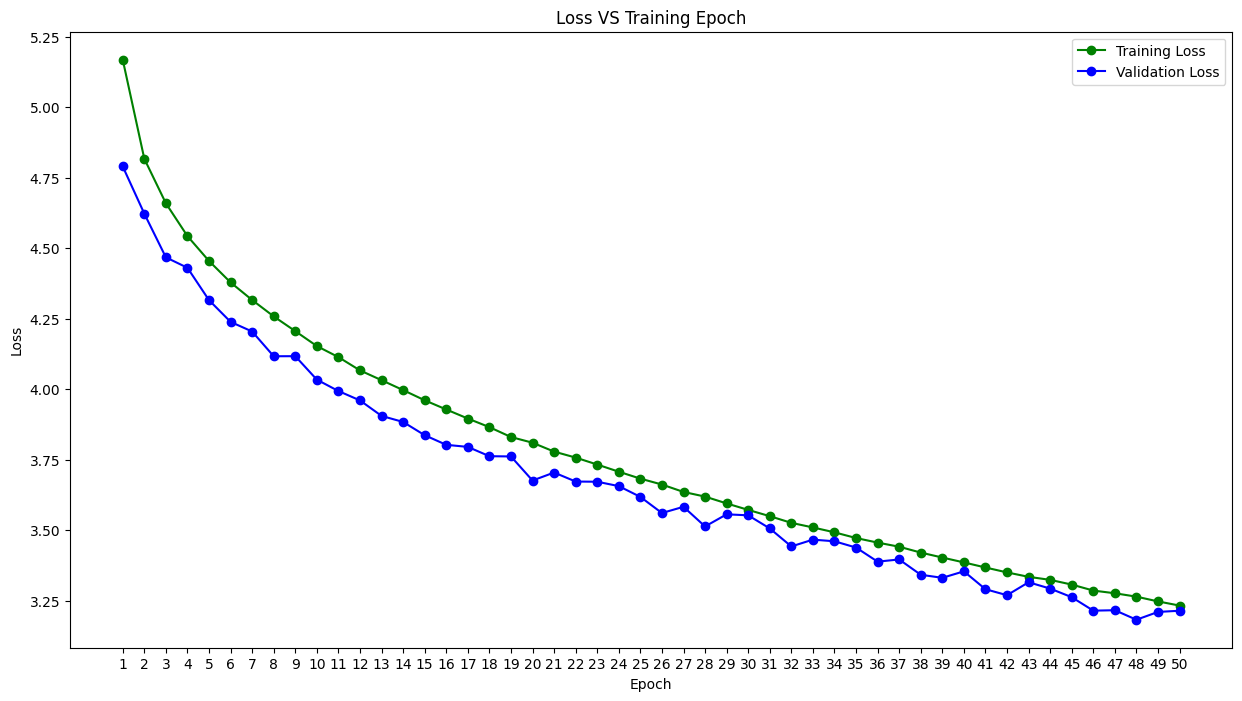

In [ ]:
# Plot training and validation loss (learning curves)
plt.figure(figsize=(15,8))
plt.plot(np.arange(actual_epochs)+1, epoch_train_loss, '-og', label="Training Loss")
plt.plot(np.arange(actual_epochs)+1, epoch_val_loss, '-ob', label="Validation Loss")
plt.title("Loss VS Training Epoch")
plt.xticks(np.arange(actual_epochs)+1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

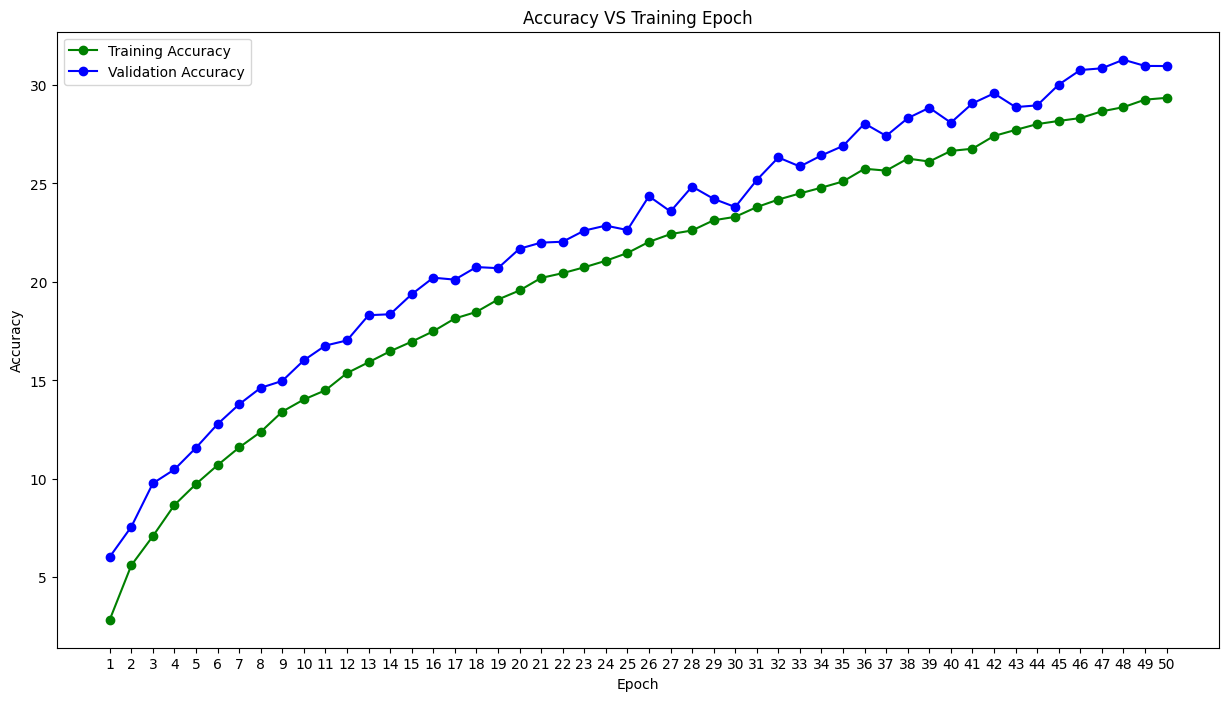

In [ ]:
# Plot training and validation accuracies (learning curves)
plt.figure(figsize=(15,8))
plt.plot(np.arange(actual_epochs)+1, epoch_train_accuracies, '-og', label="Training Accuracy")
plt.plot(np.arange(actual_epochs)+1, epoch_val_accuracies, '-ob', label="Validation Accuracy")
plt.title("Accuracy VS Training Epoch")
plt.xticks(np.arange(actual_epochs)+1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluation

In [ ]:
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()  # set model to evaluation mode

    # Initialize lists to save predictions and ground truth labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            # Move images and labels to the correct device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Pass the input through the model and get prediction
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)    # obtain predictions

            # Save prediction and ground truth label
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = torch.tensor(all_preds) == torch.tensor(all_labels)
    accuracy = accuracy.sum().item() / len(all_labels)

    # Calculate precision, recall, and f1 score with weighted average (weights = number of true instances for each class)
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Calculate precision, recall, and f1 score with macro average (not weighted)
    precision_m, recall_m, f1_m, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    return accuracy, precision_w, recall_w, f1_w, precision_m, recall_m, f1_m


In [ ]:
# Load the best model
#best_model = torch.load("/path/to/model", map_location=torch.device('cpu'))   # LOAD THE PRE-TRAINED MODEL FOR EVALUATION
                                                                               # REMOVE THE map_location IF RUNNING ON CUDA

best_model = torch.load("best-cnn.pth", weights_only=True)      # USE THIS IF TRAINING WAS PERFORMED IN THIS RUN, COMMENT OTHERWISE
model.load_state_dict(best_model)
model.to(device)

# Compute and print metrics
accuracy, precision_w, recall_w, f1_w, precision_m, recall_m, f1_m = evaluate_model(model, test_loader)

print(f'Accuracy: {accuracy:.4f}')
print(f'Weighted Average Precision: {precision_w:.4f}  -  Macro Precision: {precision_m:.4f}')
print(f'Weighted Average Recall: {recall_w:.4f}  -  Macro Recall: {recall_m:.4f}')
print(f'Weighted Average F1 Score: {f1_w:.4f}  -  Macro F1 Score: {f1_m:.4f}')

  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy: 0.3684
Weighted Average Precision: 0.3913  -  Macro Precision: 0.3745
Weighted Average Recall: 0.3684  -  Macro Recall: 0.3539
Weighted Average F1 Score: 0.3598  -  Macro F1 Score: 0.3443


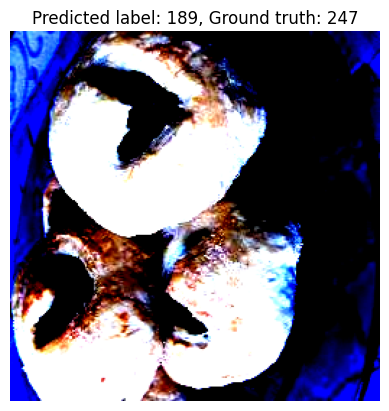

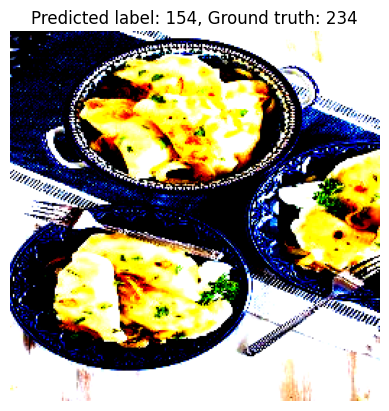

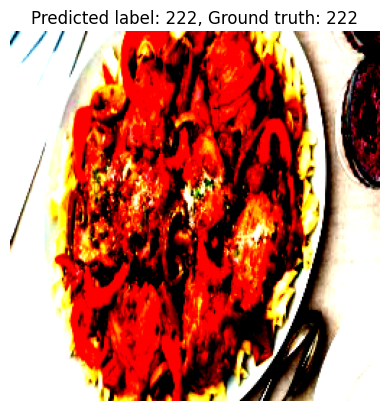

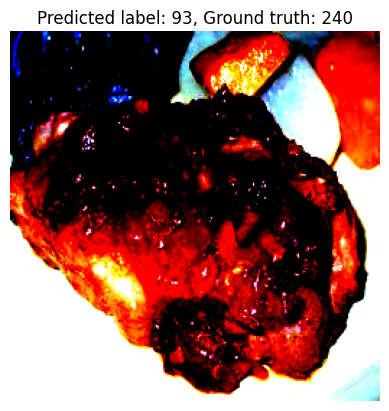

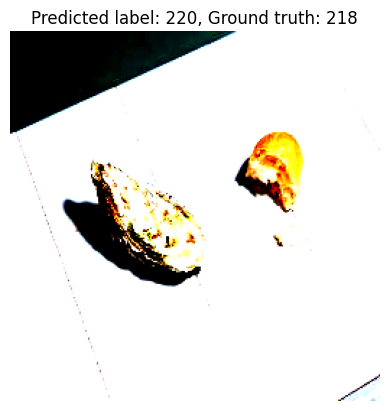

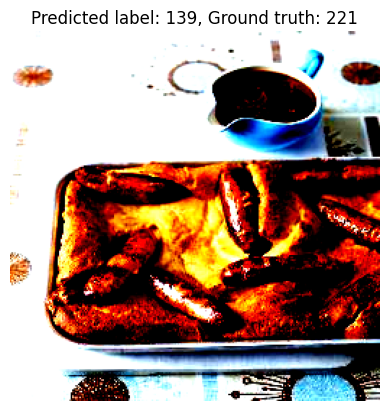

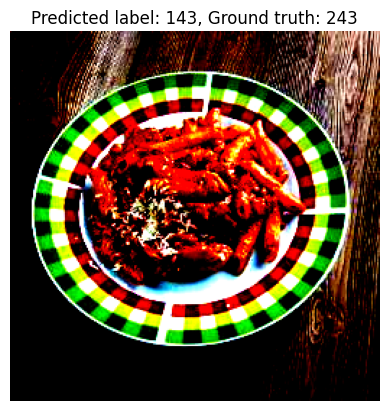

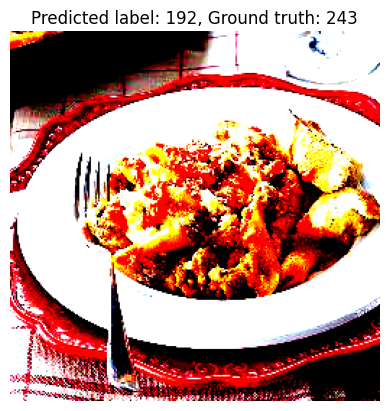

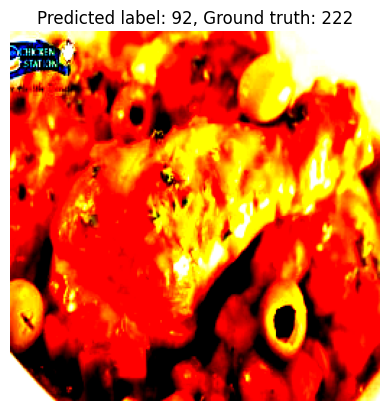

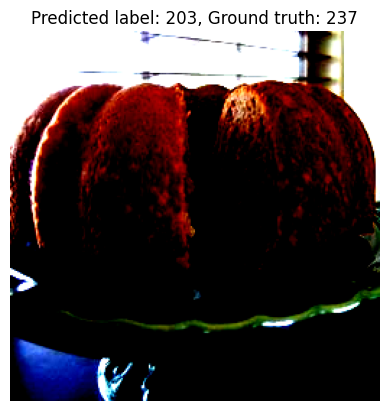

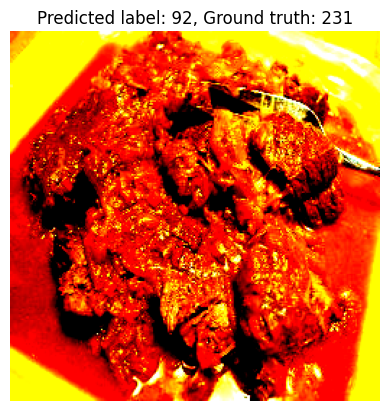

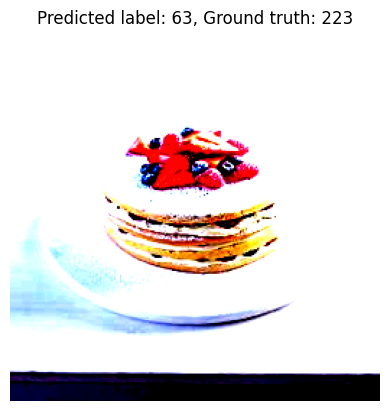

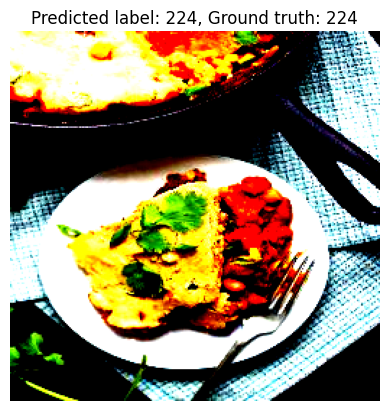

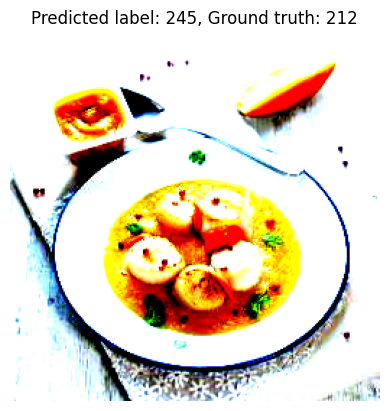

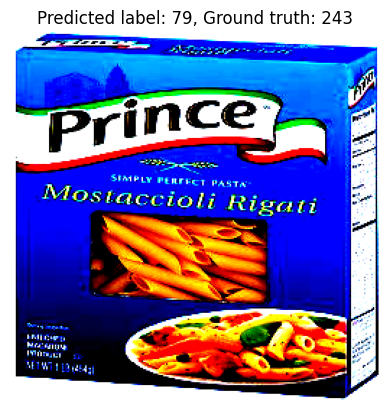

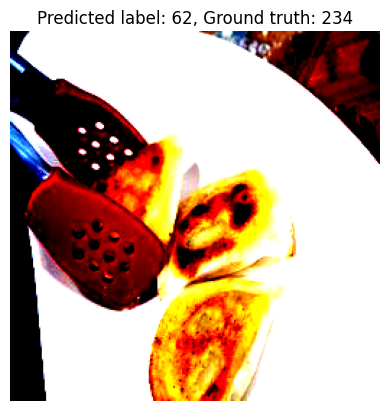

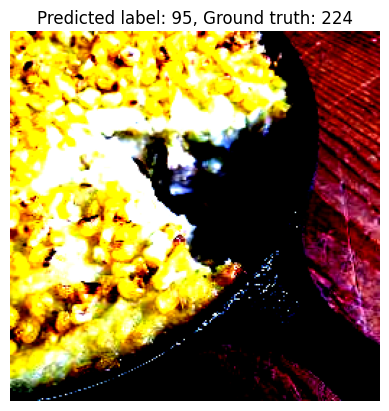

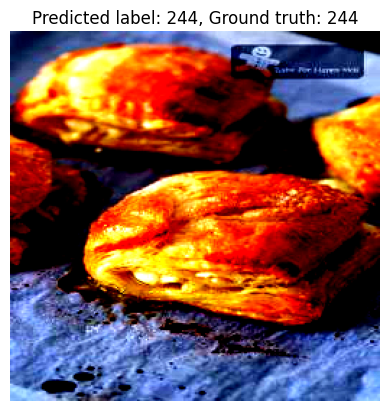

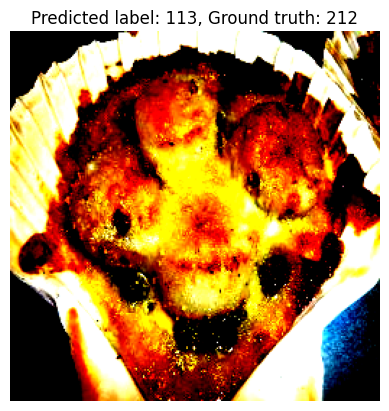

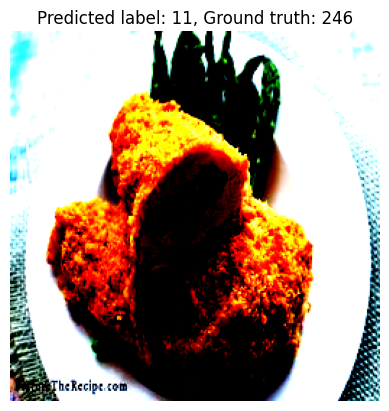

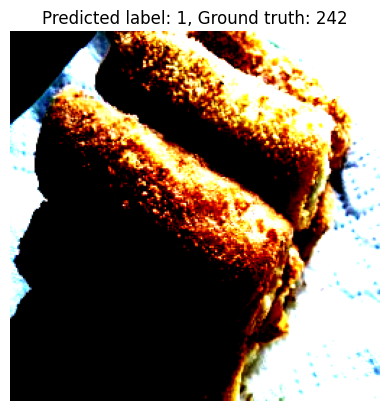

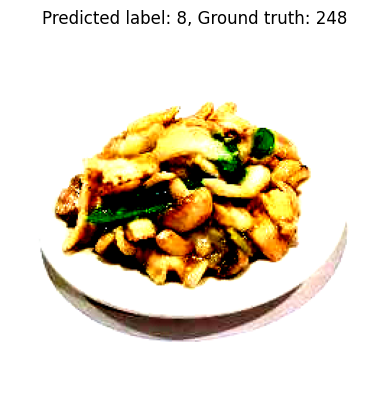

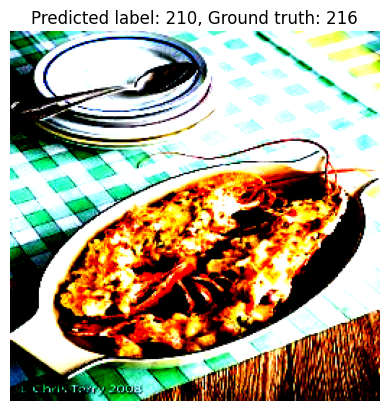

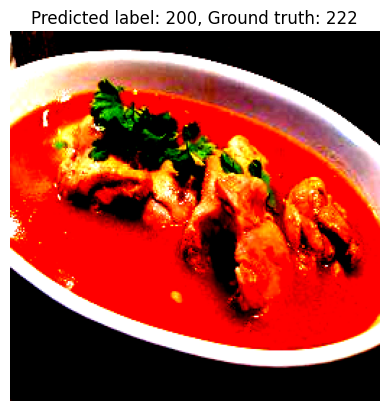

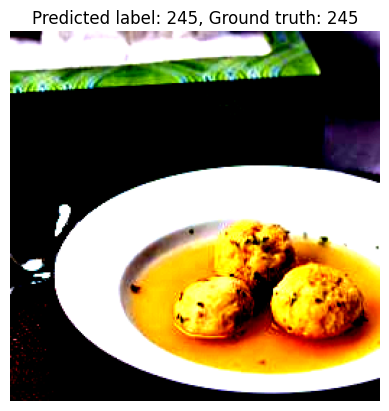

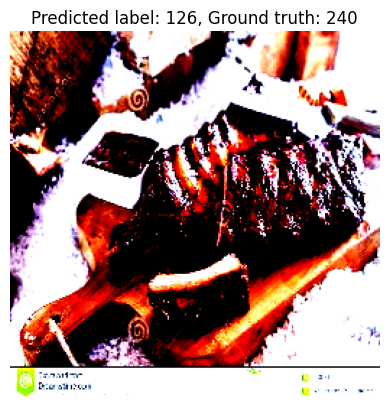

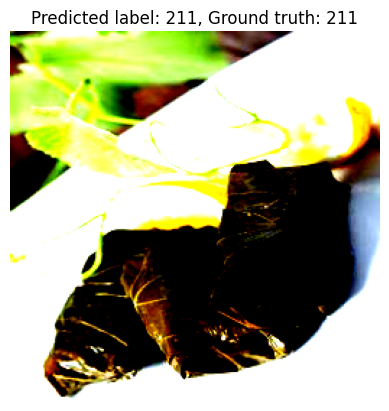

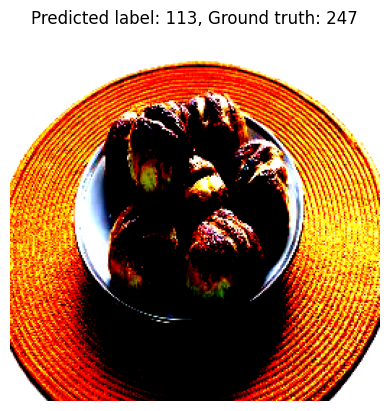

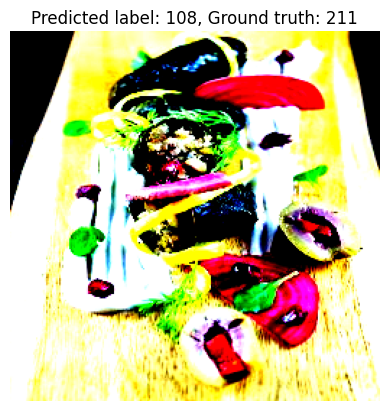

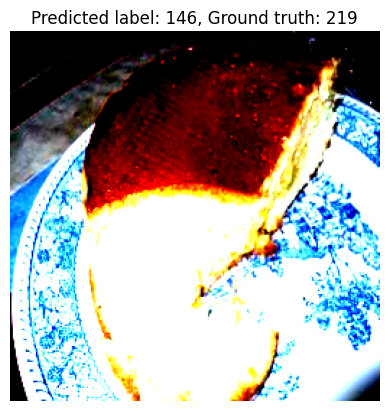

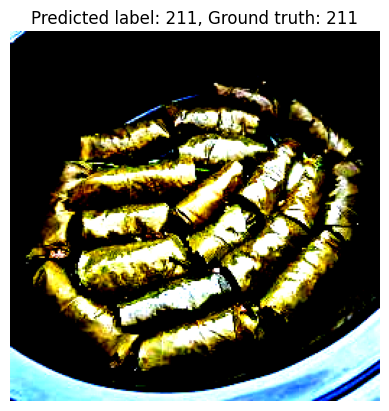

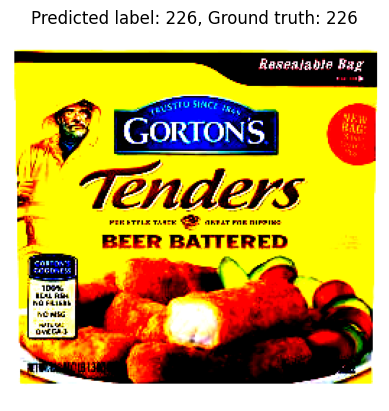

In [ ]:
# Function that displays some test images with the predicted label
def plot_predictions(model, test_loader, n=5):
    model.eval()

    # Get n examples from the test_loader
    images_shown = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move images and labels to the correct device
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)    # get predictions

            for i in range(inputs.size(0)):
                if images_shown < n:
                    # Plot image
                    img = inputs.cpu().numpy()[i].transpose(1, 2, 0)
                    plt.figure()
                    plt.imshow(img)
                    plt.title(f"Predicted label: {preds[i].item()}, Ground truth: {labels[i].item()}")
                    plt.axis('off')
                    plt.show()
                    images_shown += 1
                else:
                    return

plot_predictions(model, test_loader, n=32)